In [1]:
# If you are running this within a python venv and have the error "Module not found: numpy", 
# ensure that your kernel is set to $VENV_NAME and run $python -m ipykernel install --user --name=$VENV_NAME 
# You will need to pip install numpy, tqdm, vit_pytorch, and ipywidgets
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda as cuda
from torch.utils.data import DataLoader
import os
import time
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#import timm # Unofficial pytorch image models, for comparison
from PIL import Image
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use Nvidia GPU if available, for faster results
# Uncomment below to verify cuda is working
torch.cuda.is_available()

True

In [2]:
# Define the transformations that will be applied to the images during the loading process
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean and Std. Dev values used here are commonly used with the ImageNet dataset
])

In [3]:
# Training Settings
batch_size = 32 # This should usually be kept to a size that is a power of two
epochs = 15 # Need to monitor validation loss during training to avoid overfitting https://datascience.stackexchange.com/questions/46523/is-a-large-number-of-epochs-good-or-bad-idea-in-cnn
lr = 3e-5 # Need to implement learning rate decay 
gamma = 0.7
seed = 2147483647
# We'll use a PyTorch Generator to make things repeatable (deterministic)
g = torch.Generator().manual_seed(seed)

In [4]:
# Define path to dataset
dataset_path = "%s/../data/images/" % (os.getcwd())

# Load Datasets with labels
dset = datasets.ImageFolder(dataset_path, transform=transform) # Automatially assigns labels to examples based on the directory name

# Generate 2 splits: Train (80%), Test (20%)
dset_size = len(dset)
train_size = int(0.8 * dset_size)
test_size = dset_size - train_size

train, test = torch.utils.data.random_split(dset, [train_size, test_size], generator=g)

# Create Data Loaders fro splits
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test, batch_size=batch_size, shuffle=True)

In [5]:
# Training Statistics Init
loss_dict = {}
accuracy_dict = {}
time_to_train_dict = {}
test_accuracy_dict = {}

def train_model(model, name):
    # Loss Function
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Scheduler
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    print("")
    print("++++++++++++++++++++++++++++++++++++++++")
    print(f"Training Run [Model: {name}]")
    print("++++++++++++++++++++++++++++++++++++++++")

    # Training Statistics Init
    loss_list = []
    accuracy_list = []
    
    # Training Time
    start_event = cuda.Event(enable_timing=True)
    end_event = cuda.Event(enable_timing=True)
    # Begin Clock
    start_event.record()
    
    # Training Loop
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in tqdm(train_dl):
            data = data.to(device) # Ensure we're processing data on GPU
            label = label.to(device)
        
            output = model(data)
            loss = criterion(output, label)
        
            optimizer.zero_grad() # Zero out the gradient -- we'll experience weird bugs if we forget to do so
            loss.backward()
            optimizer.step()
        
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_dl)
            epoch_loss += loss / len(train_dl)
        
        print(f"Epoch: {epoch+1} - loss: {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}")
        loss_list.append(epoch_loss.cpu().detach().numpy().item())
        accuracy_list.append(epoch_accuracy.cpu().detach().numpy().item())
       
    # End Clock
    end_event.record()
    cuda.synchronize() # Wait for GPU operations to complete
    time = start_event.elapsed_time(end_event) / 1000 # Convert to seconds
    num_examples = batch_size * len(train_dl)
    time_per_example = time / (num_examples * epochs)
    print(f"It took {time} seconds to train {name} on {num_examples} examples over {epochs} epochs.")
    print(f"That averages to {time_per_example} seconds per example")

    # Test run
    print("++++++++++++++++++++++++++++++++++++++++")
    print(f"Test Run [Model: {name}] ")
    print("++++++++++++++++++++++++++++++++++++++++")
    accuracies = []
    batch_acc = 0
    for data, label in tqdm(test_dl):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        acc = (output.argmax(dim=1) == label).float().mean().cpu().detach().numpy()
        batch_acc += acc / len(test_dl)
        accuracies.append(batch_acc)
        
    print(f"Test Accuracy: {accuracies[-1]} - Number of test cases: {len(test_dl) * batch_size}")

    # Update training stats
    loss_dict.update({name: loss_list})
    accuracy_dict.update({name: accuracy_list})
    time_to_train_dict.update({name: time_per_example})
    test_accuracy_dict.update({name: accuracies[-1]})

In [6]:
# VanillaViT
# Need to get rid of magic numers here
from vit_pytorch import ViT

VanillaViT = ViT(
    image_size = 128,
    patch_size = 8,
    num_classes = 23,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
train_model(VanillaViT, "VanillaViT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: VanillaViT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.7240 - acc: 0.3896


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.6389 - acc: 0.4152


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.5764 - acc: 0.4416


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.4879 - acc: 0.4706


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.3307 - acc: 0.5377


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.1408 - acc: 0.6074


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 0.8975 - acc: 0.6952


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 0.6784 - acc: 0.7717


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 0.4982 - acc: 0.8359


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 0.3803 - acc: 0.8740


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 0.3082 - acc: 0.9020


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 0.2728 - acc: 0.9185


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 0.2286 - acc: 0.9293


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 0.1993 - acc: 0.9426


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 0.2033 - acc: 0.9422
It took 2265.8045 seconds to train VanillaViT on 9408 examples over 15 epochs.
That averages to 0.016055870890022677 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: VanillaViT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.38713144974128605 - Number of test cases: 2368


In [6]:
# SimpleViT 
from vit_pytorch import SimpleViT

SimpleViT = SimpleViT(
    image_size = 128,
    patch_size = 8,
    num_classes = 23,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048
).to(device)
train_model(SimpleViT, "SimpleViT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: SimpleViT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.7303 - acc: 0.3918


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.6522 - acc: 0.4079


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.5991 - acc: 0.4245


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.5116 - acc: 0.4594


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.4256 - acc: 0.4940


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.3024 - acc: 0.5359


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 1.1381 - acc: 0.6038


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 0.9230 - acc: 0.6819


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 0.6526 - acc: 0.7798


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 0.4359 - acc: 0.8658


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 0.2726 - acc: 0.9220


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 0.2077 - acc: 0.9470


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 0.1608 - acc: 0.9620


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 0.1414 - acc: 0.9677


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 0.1213 - acc: 0.9722
It took 2035.4465 seconds to train SimpleViT on 9408 examples over 15 epochs.
That averages to 0.014423515447845805 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: SimpleViT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.46391277659583735 - Number of test cases: 2368


In [7]:
# T2TViT
from vit_pytorch.t2t import T2TViT

T2TViT = T2TViT(
    dim = 512,
    image_size = 128,
    depth = 5,
    heads = 8,
    mlp_dim = 512,
    num_classes = 23,
    t2t_layers = ((7, 4), (3, 2), (3, 2)) # tuples of the kernel size and stride of  each consecutive layers of the initial token to token module
).to(device)
train_model(T2TViT, "T2TViT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: T2TViT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.7316 - acc: 0.3883


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.6566 - acc: 0.4169


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.6224 - acc: 0.4192


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.5937 - acc: 0.4258


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.5557 - acc: 0.4449


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.4912 - acc: 0.4680


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 1.3832 - acc: 0.5106


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 1.2099 - acc: 0.5744


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 0.9365 - acc: 0.6756


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 0.6287 - acc: 0.8003


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 0.4039 - acc: 0.8782


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 0.2566 - acc: 0.9305


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 0.1702 - acc: 0.9593


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 0.1353 - acc: 0.9686


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 0.1142 - acc: 0.9719
It took 740.843375 seconds to train T2TViT on 9408 examples over 15 epochs.
That averages to 0.0052497404691043085 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: T2TViT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.40605804686610775 - Number of test cases: 2368


In [8]:
# CrossViT
from vit_pytorch.cross_vit import CrossViT

CrossViT = CrossViT(
    image_size = 128,
    num_classes = 23,
    depth = 4,               # number of multi-scale encoding blocks
    sm_dim = 192,            # high res dimension
    sm_patch_size = 16,      # high res patch size (should be smaller than lg_patch_size)
    sm_enc_depth = 2,        # high res depth
    sm_enc_heads = 8,        # high res heads
    sm_enc_mlp_dim = 2048,   # high res feedforward dimension
    lg_dim = 384,            # low res dimension
    lg_patch_size = 64,      # low res patch size
    lg_enc_depth = 3,        # low res depth
    lg_enc_heads = 8,        # low res heads
    lg_enc_mlp_dim = 2048,   # low res feedforward dimensions
    cross_attn_depth = 2,    # cross attention rounds
    cross_attn_heads = 8,    # cross attention heads
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
train_model(CrossViT, "CrossViT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: CrossViT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.7479 - acc: 0.3767


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.6642 - acc: 0.4072


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.6131 - acc: 0.4140


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.5586 - acc: 0.4348


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.4925 - acc: 0.4632


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.4031 - acc: 0.4999


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 1.2868 - acc: 0.5477


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 1.1609 - acc: 0.5997


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 1.0088 - acc: 0.6476


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 0.8609 - acc: 0.7050


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 0.7254 - acc: 0.7457


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 0.6106 - acc: 0.7906


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 0.5068 - acc: 0.8282


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 0.4237 - acc: 0.8570


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 0.3533 - acc: 0.8862
It took 428.97025 seconds to train CrossViT on 9408 examples over 15 epochs.
That averages to 0.0030397551729024943 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: CrossViT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.3566492630823237 - Number of test cases: 2368


In [9]:
# PiT
# install these
from vit_pytorch.pit import PiT

PiT = PiT(
    image_size = 128,
    patch_size = 16,
    dim = 256,
    num_classes = 23,
    depth = (3, 3, 3),     # list of depths, indicating the number of rounds of each stage before a downsample
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
train_model(PiT, "PiT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: PiT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.7540 - acc: 0.3820


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.7194 - acc: 0.3826


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.7104 - acc: 0.3909


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.7083 - acc: 0.3920


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.7019 - acc: 0.3913


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.6957 - acc: 0.3934


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 1.6856 - acc: 0.3933


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 1.6718 - acc: 0.3959


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 1.6478 - acc: 0.4055


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 1.6336 - acc: 0.4082


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 1.6114 - acc: 0.4118


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 1.5966 - acc: 0.4222


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 1.5749 - acc: 0.4284


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 1.5585 - acc: 0.4323


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 1.5424 - acc: 0.4374
It took 696.2998125 seconds to train PiT on 9408 examples over 15 epochs.
That averages to 0.00493409731079932 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: PiT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.4195715603796211 - Number of test cases: 2368


In [10]:
# LeViT
from vit_pytorch.levit import LeViT

LeViT = LeViT(
    image_size = 128,
    num_classes = 23,
    stages = 3,             # number of stages
    dim = (256, 384, 512),  # dimensions at each stage
    depth = 4,              # transformer of depth 4 at each stage
    heads = (4, 6, 8),      # heads at each stage
    mlp_mult = 2,
    dropout = 0.1
).to(device)
train_model(LeViT, "LeViT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: LeViT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.8930 - acc: 0.3899


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.7009 - acc: 0.3955


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.6891 - acc: 0.3950


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.6785 - acc: 0.3921


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.6718 - acc: 0.3959


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.6546 - acc: 0.4020


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 1.6420 - acc: 0.4085


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 1.6224 - acc: 0.4207


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 1.5906 - acc: 0.4353


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 1.5467 - acc: 0.4564


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 1.5007 - acc: 0.4815


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 1.4378 - acc: 0.5095


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 1.3648 - acc: 0.5434


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 1.2705 - acc: 0.5748


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 1.2048 - acc: 0.5974
It took 337.3079375 seconds to train LeViT on 9408 examples over 15 epochs.
That averages to 0.0023902206455498863 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: LeViT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.3727733416331781 - Number of test cases: 2368


In [11]:
# CvT
from vit_pytorch.cvt import CvT

CvT = CvT(
    num_classes = 23,
    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 1,           # stage 1 - heads
    s1_depth = 1,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor
    s2_emb_dim = 192,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 2,
    s2_mlp_mult = 4,
    s3_emb_dim = 384,       # stage 3 - (same as above)
    s3_emb_kernel = 3,
    s3_emb_stride = 2,
    s3_proj_kernel = 3,
    s3_kv_proj_stride = 2,
    s3_heads = 4,
    s3_depth = 10,
    s3_mlp_mult = 4,
    dropout = 0,
).to(device)
train_model(CvT, "CvT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: CvT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.7609 - acc: 0.3722


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.6741 - acc: 0.3914


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.6127 - acc: 0.4129


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.5616 - acc: 0.4281


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.4917 - acc: 0.4531


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.4044 - acc: 0.4822


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 1.2706 - acc: 0.5392


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 1.0981 - acc: 0.6039


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 0.9079 - acc: 0.6762


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 0.7064 - acc: 0.7588


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 0.5498 - acc: 0.8130


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 0.4250 - acc: 0.8607


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 0.3425 - acc: 0.8917


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 0.2834 - acc: 0.9118


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 0.2349 - acc: 0.9310
It took 375.94159375 seconds to train CvT on 9408 examples over 15 epochs.
That averages to 0.002663985216482426 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: CvT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.34528562668207535 - Number of test cases: 2368


In [6]:
# ScalableViT
from vit_pytorch.scalable_vit import ScalableViT

ScalableViT = ScalableViT(
    num_classes = 23,
    dim = 64,                               # starting model dimension. at every stage, dimension is doubled
    heads = (2, 4, 8, 16),                  # number of attention heads at each stage
    depth = (2, 2, 20, 2),                  # number of transformer blocks at each stage
    ssa_dim_key = (40, 40, 40, 32),         # the dimension of the attention keys (and queries) for SSA. in the paper, they represented this as a scale factor on the base dimension per key (ssa_dim_key / dim_key)
    reduction_factor = (8, 4, 2, 1),        # downsampling of the key / values in SSA. in the paper, this was represented as (reduction_factor ** -2)
    window_size = (32, 16, None, None),     # window size of the IWSA at each stage. None means no windowing needed
    dropout = 0.1,                          # attention and feedforward dropout
).to(device)
train_model(ScalableViT, "ScalableViT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: ScalableViT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.7343 - acc: 0.3831


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.7091 - acc: 0.3875


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.6911 - acc: 0.3891


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.6915 - acc: 0.3905


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.6862 - acc: 0.3936


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.6832 - acc: 0.3930


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 1.6800 - acc: 0.3883


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 1.6708 - acc: 0.3943


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 1.6639 - acc: 0.3920


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 1.6589 - acc: 0.3955


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 1.6416 - acc: 0.3992


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 1.6324 - acc: 0.4044


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 1.6144 - acc: 0.4148


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 1.6085 - acc: 0.4200


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 1.5885 - acc: 0.4308
It took 1411.68425 seconds to train ScalableViT on 9408 examples over 15 epochs.
That averages to 0.01000343147675737 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: ScalableViT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.3664388821737186 - Number of test cases: 2368


In [7]:
# MobileViT
from vit_pytorch.mobile_vit import MobileViT

MobileViT = MobileViT(
    image_size = (128, 128),
    dims = [96, 120, 144],
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
    num_classes = 23,
).to(device)
train_model(MobileViT, "MobileViT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: MobileViT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 2.7423 - acc: 0.3019


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 2.0993 - acc: 0.4089


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.7100 - acc: 0.4886


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.3905 - acc: 0.5838


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.1375 - acc: 0.6679


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 0.9425 - acc: 0.7252


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 0.8288 - acc: 0.7616


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 0.7267 - acc: 0.7938


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 0.6362 - acc: 0.8210


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 0.5870 - acc: 0.8399


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 0.5255 - acc: 0.8515


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 0.5057 - acc: 0.8566


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 0.4549 - acc: 0.8709


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 0.4208 - acc: 0.8791


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 0.4084 - acc: 0.8815
It took 316.05728125 seconds to train MobileViT on 9408 examples over 15 epochs.
That averages to 0.0022396349294926303 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: MobileViT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.3384136976422491 - Number of test cases: 2368


In [8]:
# SmallDataViT
from vit_pytorch.vit_for_small_dataset import ViT as SmallDataViT

SmallDataViT = SmallDataViT(
    image_size = 128,
    patch_size = 16,
    num_classes = 23,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
train_model(SmallDataViT, "SmallDataViT")


++++++++++++++++++++++++++++++++++++++++
Training Run [Model: SmallDataViT]
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 1 - loss: 1.7365 - acc: 0.3827


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 2 - loss: 1.6516 - acc: 0.4130


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 3 - loss: 1.5871 - acc: 0.4339


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 4 - loss: 1.5247 - acc: 0.4538


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 5 - loss: 1.4223 - acc: 0.5005


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 6 - loss: 1.3151 - acc: 0.5415


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 7 - loss: 1.1706 - acc: 0.5892


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 8 - loss: 0.9911 - acc: 0.6545


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 9 - loss: 0.8030 - acc: 0.7220


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 10 - loss: 0.6300 - acc: 0.7856


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 11 - loss: 0.5119 - acc: 0.8269


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 12 - loss: 0.4080 - acc: 0.8594


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 13 - loss: 0.3474 - acc: 0.8836


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 14 - loss: 0.2867 - acc: 0.9068


  0%|          | 0/294 [00:00<?, ?it/s]

Epoch: 15 - loss: 0.2548 - acc: 0.9200
It took 597.213875 seconds to train SmallDataViT on 9408 examples over 15 epochs.
That averages to 0.004231957731009071 seconds per example
++++++++++++++++++++++++++++++++++++++++
Test Run [Model: SmallDataViT] 
++++++++++++++++++++++++++++++++++++++++


  0%|          | 0/74 [00:00<?, ?it/s]

Test Accuracy: 0.3722742630823236 - Number of test cases: 2368


In [9]:
models = ["VanillaViT", "SimpleViT", "T2TViT", "CrossViT", "PiT", "LeViT", "CvT", "ScalableViT", "MobileViT", "SmallDataViT"]

In [10]:
print(loss_dict)
print(accuracy_dict)
print(time_to_train_dict)
print(test_accuracy_dict)

{'ScalableViT': [1.7343404293060303, 1.709108591079712, 1.6910871267318726, 1.6914695501327515, 1.686190128326416, 1.6832268238067627, 1.6800265312194824, 1.670791745185852, 1.663947343826294, 1.6588705778121948, 1.6415655612945557, 1.632414698600769, 1.6144095659255981, 1.6085401773452759, 1.588536262512207], 'MobileViT': [2.742335796356201, 2.0992603302001953, 1.7100157737731934, 1.3905035257339478, 1.1375365257263184, 0.9424824714660645, 0.8287878036499023, 0.72666996717453, 0.6362184882164001, 0.5870349407196045, 0.5255374908447266, 0.5057481527328491, 0.4548821747303009, 0.42083239555358887, 0.40840885043144226], 'SmallDataViT': [1.7365204095840454, 1.651606798171997, 1.5871479511260986, 1.5247238874435425, 1.4223389625549316, 1.315065622329712, 1.1705970764160156, 0.9911053776741028, 0.8030253648757935, 0.6300288438796997, 0.51186603307724, 0.4080023467540741, 0.3474409580230713, 0.28671538829803467, 0.25482839345932007]}
{'ScalableViT': [0.3831489682197571, 0.3874952793121338, 0

ValueError: x, y, and format string must not be None

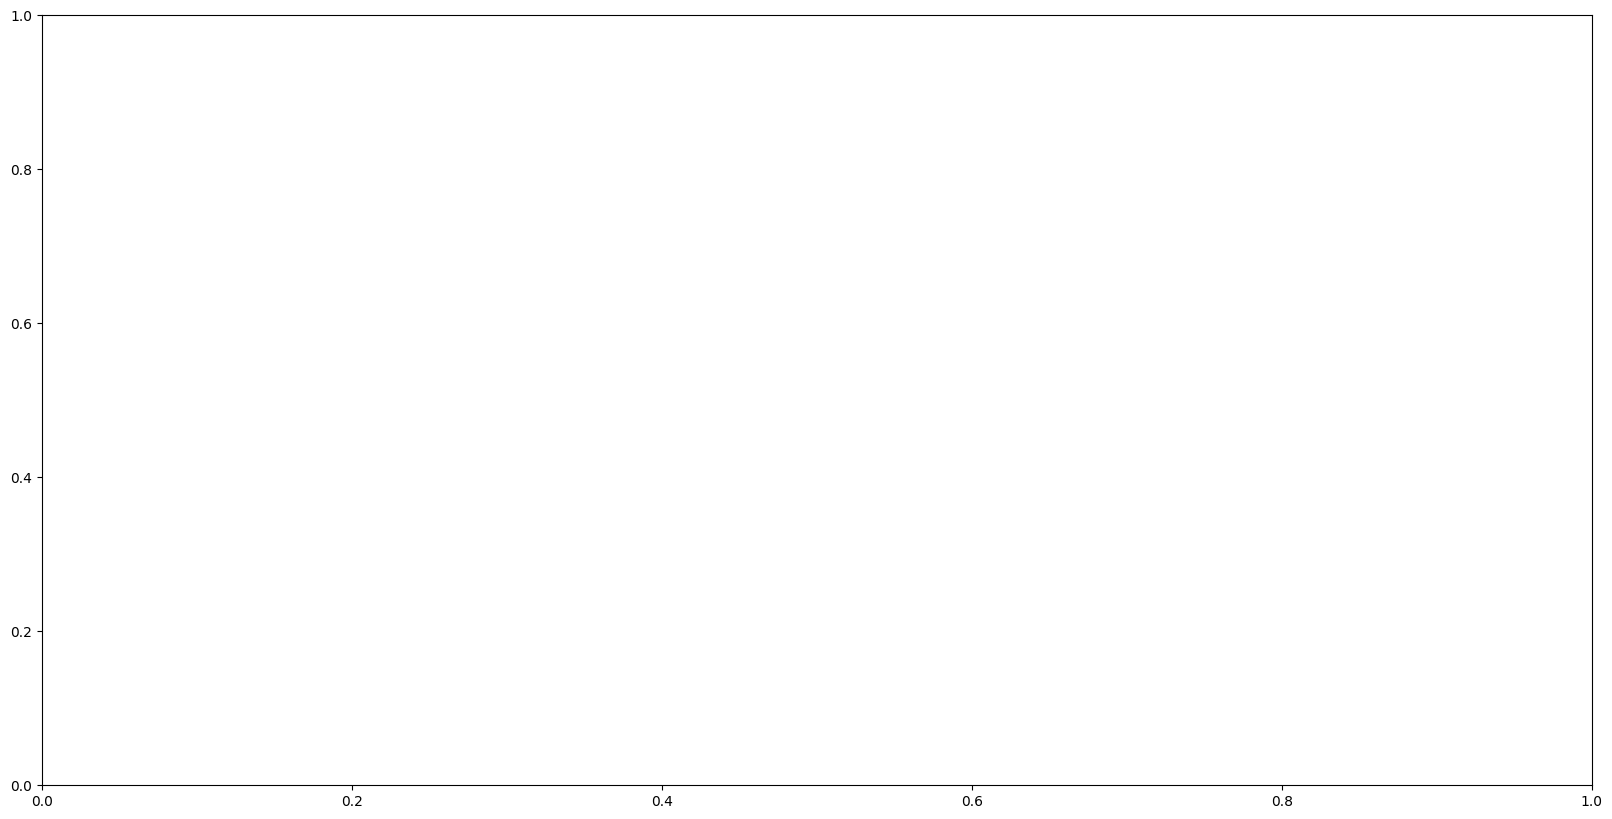

In [12]:
# Background Loss
plt.figure(figsize=(20,10))
for model in models:
    loss_list = loss_dict.get(model)
    plt.plot(loss_list, label=model)

plt.xticks(range(0,10), labels=range(1,11))
plt.grid(True)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss (Cross Entropy)", fontsize=14)
plt.title("Training Loss Convergence", fontsize=16)
plt.legend()

plt.show()

In [ ]:
# Accuracy Convergence
plt.figure(figsize=(20,10))
for model in models:
    acc_list = accuracy_dict[model]
    plt.plot(acc_list, label=model)

plt.xticks(range(0,10), labels=range(1,11))
plt.grid(True)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy (Percentage Points)", fontsize=14)
plt.title("Training Accuracy Convergence")
plt.legend()

plt.show()

In [ ]:
# Final Training Accuracy
acc_list = []
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan' ]
for model in models:
    acc_list.append(accuracy_dict[model])

plt.figure(figsize=(20,10))
plt.bar(models, acc_list, color=colors)
plt.xlabel("Models")
plt.ylabel("Accuracy (Percentage Points)")
plt.title("Accuracy Comparison of Vision Transformer Variants")
plt.show()

In [ ]:
# Training Time
times_list = []
for model in models:
    times_list.append(time_to_train_dict[model])
    
plt.figure(figsize=(20, 10))
plt.bar(models, times_list, color=colors)
plt.xlabel("Models")
plt.ylabel("Training Time (per Example)")
plt.title("Training Time Comparison of Vision Transformer Variants")
plt.show()

In [ ]:
# Perform Inference using model
import torchvision.transforms.functional as TF

# Classes defined in alphabetical order
classes = [
    "Ammobatoidini",
    "Andrenini",
    "Anthidiini",
    "Anthophorini",
    "Apini",
    "Augochlorini",
    "Bombini",
    "Calliopsini",
    "Caupolicanini",
    "Ceratinini",
    "Emphorini",
    "Epeolini",
    "Eucerini",
    "Halictini",
    "Megachilini",
    "Melectini",
    "Nomadini",
    "Osmiini",
    "Panurgini",
    "Protandrenini",
    "Sphecodini",
    "Xylocopini",
]

# Load our demo image (taken from test set)
demo_images = {
    "Augochlorini_2870.jpg": "Augochlorini",
    "Bombini_129.jpg": "Bombini",
    "Halictini_745.jpg": "Halictini",
    "Osmiini_1551.jpg": "Osmiini",
}

def demo(filename, ground_truth):

    demo_image_path = "{}/../data/demo_img/{}".format(os.getcwd(), filename)
    demo_img = Image.open(demo_image_path).resize((128,128), resample=0)

    # Display image
    display(demo_img)

    # Outputs a vector displaying the models predictions
    demo_img = TF.to_tensor(demo_img)
    demo_img.unsqueeze_(0) #need to provide the batch dimension at dim0
    demo_img = demo_img.to(device)
    predictions = VanillaViT(demo_img)

    # Get index of max value (most confident prediction)
    tribe = torch.argmax(predictions)

    print("The VanillaViT model believes this bee is a {}".format(classes[tribe]))
    print("Ground truth: This bee is a {}".format(ground_truth))

for key, value in demo_images.items(): 
    demo(key, value)